## データの読み込み

In [1]:
import scripts.FilterBank as fb
import scripts.AlgoIntro as ai
import scripts.AlgoSparseReg as asr

import numpy as np
import math

# Import the vim-2 data from the Python binary format we saved earlier.
# Assumptions: that the data is saved in the vim-2 directory,
# already of 96x96 size, with dtype of np.float32.

PIX_W = 48
PIX_H = 48
dtype=np.float32

# Read the raw training data.
shape=(PIX_W,PIX_H,3,108000) # (downsized px, downsized px, rgd channels, time steps)
# Index for temporal down-sampling. Alternatives: do after the feature-building and aggregate.
idx_ds = np.arange(15//2, 108000+1, 15) # need length 7200.
fname = "data/vim-2/X_tr.dat"
with open(fname, mode="br") as fbin:
    print("Reading...", end=" ")
    raw_tr = np.fromfile(file=fbin,dtype=dtype).reshape(shape)[:,:,:,idx_ds] # temporally down-sampled.
    print("OK.")

# Read the raw testing data.
shape=(PIX_W,PIX_H,3,8100) # (downsized px, downsized px, rgd channels, time steps)
# Index for temporal down-sampling. Alternatives: do after the feature-building and aggregate.
idx_ds = np.arange(15//2, 8100+1, 15) # need length 540.
fname = "data/vim-2/X_te.dat"
with open(fname, mode="br") as fbin:
    print("Reading...", end=" ")
    raw_te = np.fromfile(file=fbin, dtype=dtype).reshape(shape)[:,:,:,idx_ds] # temporally down-sampled.
    print("OK.")

    

Reading... OK.
Reading... OK.


## 特徴量の作成

In [2]:
def get_features(freqs, direction, amp, sdev, phase, mygrid_h, mygrid_w):

    myparas = {"freqs": freqs,
               "dir": direction,
               "amp": amp,
               "sdev": sdev,
               "phase": phase}

    X_tr = fb.G2_getfeatures(ims=raw_tr,
                             fil_paras=myparas,
                             gridshape=(mygrid_h,mygrid_w),
                             mode="reflect", cval=0)

    X_te = fb.G2_getfeatures(ims=raw_te,
                             fil_paras=myparas,
                             gridshape=(mygrid_h,mygrid_w),
                             mode="reflect", cval=0)
    
    return X_tr, X_te


In [3]:
# grid_list = [5, 10]
# freqs_list = [20/max(PIX_W,PIX_H), 40/max(PIX_W,PIX_H)]
# direction_list = [0, math.pi/4, math.pi/2, 3*math.pi/4]
# sdev_list = [max(PIX_W,PIX_H)/20, max(PIX_W,PIX_H)/30]

grid_list = [10]
freqs_list = [20/max(PIX_W,PIX_H), 30/max(PIX_W,PIX_H), 40/max(PIX_W,PIX_H)]
direction_list = [0, math.pi/3, 2*math.pi/3,math.pi/2, 4*math.pi/3, 4*math.pi/3]
sdev_list = [max(PIX_W,PIX_H)/20, max(PIX_W,PIX_H)/30]

param_list = []

for grid in grid_list:
    for freqs in freqs_list:
        for direction in direction_list:
            for sdev in sdev_list:
                param_list.append({
                    'freqs':freqs,
                    'direction': direction,
                    'amp': 0.1,
                    'sdev': sdev,
                    'phase': 0,
                    'mygrid_h': grid,
                    'mygrid_w': grid
                })

In [4]:
X_tr = None
X_te = None

for param in param_list:
    print(param)
    X_tr_tmp, X_te_tmp = get_features(
        freqs=param['freqs'],
        direction=param['direction'],
        amp=param['amp'],
        sdev=param['sdev'],
        phase=param['phase'],
        mygrid_h=param['mygrid_h'],
        mygrid_w=param['mygrid_w'])
    
    if type(X_tr) == np.ndarray:
        X_tr = np.concatenate((X_tr, X_tr_tmp), axis=1)
    else:
        X_tr = X_tr_tmp
        
    if type(X_te) == np.ndarray:
        X_te = np.concatenate((X_te, X_te_tmp), axis=1)
    else:
        X_te = X_te_tmp

{'sdev': 2.4, 'mygrid_h': 10, 'amp': 0.1, 'mygrid_w': 10, 'phase': 0, 'freqs': 0.4166666666666667, 'direction': 0}
{'sdev': 1.6, 'mygrid_h': 10, 'amp': 0.1, 'mygrid_w': 10, 'phase': 0, 'freqs': 0.4166666666666667, 'direction': 0}
{'sdev': 2.4, 'mygrid_h': 10, 'amp': 0.1, 'mygrid_w': 10, 'phase': 0, 'freqs': 0.4166666666666667, 'direction': 1.0471975511965976}
{'sdev': 1.6, 'mygrid_h': 10, 'amp': 0.1, 'mygrid_w': 10, 'phase': 0, 'freqs': 0.4166666666666667, 'direction': 1.0471975511965976}
{'sdev': 2.4, 'mygrid_h': 10, 'amp': 0.1, 'mygrid_w': 10, 'phase': 0, 'freqs': 0.4166666666666667, 'direction': 2.0943951023931953}
{'sdev': 1.6, 'mygrid_h': 10, 'amp': 0.1, 'mygrid_w': 10, 'phase': 0, 'freqs': 0.4166666666666667, 'direction': 2.0943951023931953}
{'sdev': 2.4, 'mygrid_h': 10, 'amp': 0.1, 'mygrid_w': 10, 'phase': 0, 'freqs': 0.4166666666666667, 'direction': 1.5707963267948966}
{'sdev': 1.6, 'mygrid_h': 10, 'amp': 0.1, 'mygrid_w': 10, 'phase': 0, 'freqs': 0.4166666666666667, 'direction'

In [5]:
print("Shape of the produced features:")
print("tr:", X_tr.shape)
print("te:", X_te.shape)

Shape of the produced features:
tr: (7200, 3600)
te: (540, 3600)


## 特徴量の正規化

In [6]:
X_tr = X_tr - np.mean(X_tr, axis=0)
X_tr = X_tr / np.std(X_tr, axis=0)
# print("Mean =", np.mean(X_tr, axis=0), "StdDev =", np.std(X_tr, axis=0), "Shape =", X_tr.shape)

X_te = X_te - np.mean(X_te, axis=0)
X_te = X_te / np.std(X_te, axis=0)
# print("Mean =", np.mean(X_te, axis=0), "StdDev =", np.std(X_te, axis=0), "Shape =", X_te.shape)

for j in range(X_tr.shape[1]):
    stdval = np.std(X_tr[:,j])
    X_tr[:,j] = np.clip(X_tr[:,j], a_min=(-stdval), a_max=stdval)
    stdval = np.std(X_te[:,j])
    X_te[:,j] = np.clip(X_te[:,j], a_min=(-stdval), a_max=stdval)


## 特徴量をディスクへ書き込み

In [7]:
import support.classes as classes

# Make a data_info file for this data, and save as data/encoder/info.dat.
dinfo = classes.DataInfo()
dinfo.mname = "Encoder"

fname = "data/encoder/X_tr.dat"
dtype = raw_tr.dtype
shape = raw_tr.shape
with open(fname, mode="bw") as fbin:
    X_tr.tofile(fbin)
    print("Saved to file.")
dinfo.X_tr["shape"] = X_tr.shape
dinfo.X_tr["path"] = "data/encoder/X_tr.dat"
dinfo.X_tr["dtype"] = X_tr.dtype
    
fname = "data/encoder/X_te.dat"
dtype = raw_te.dtype
shape = raw_te.shape
with open(fname, mode="bw") as fbin:
    X_te.tofile(fbin)
    print("Saved to file.")
dinfo.X_te["shape"] = X_te.shape
dinfo.X_te["path"] = "data/encoder/X_te.dat"
dinfo.X_te["dtype"] = X_te.dtype

Saved to file.
Saved to file.


## 応答をディスクへ書き込み

In [8]:

import pickle

fname = "data/encoder/y_tr.dat"
dinfo.y_tr["shape"] = (73728, 7200)
dinfo.y_tr["path"] = "data/encoder/y_tr.dat"
dinfo.y_tr["dtype"] = np.float32

fname = "data/encoder/y_te.dat"
dinfo.y_te["shape"] = (73728, 540)
dinfo.y_te["path"] = "data/encoder/y_te.dat"
dinfo.y_te["dtype"] = np.float32

dinfo.misc = {"voxidx": None} # to be filled in later.

with open("data/encoder/info.dat", mode="bw") as fbin:
    pickle.dump(dinfo, fbin)
    print("Saved to file.")


Saved to file.


## モデルの初期化

In [3]:
import numpy as np
import math
import pickle
import support.parse_model as mp
import scripts.AlgoSparseReg as asr

# Load the general data info object.
with open("data/encoder/info.dat", mode="br") as fbin:
    dinfo = pickle.load(fbin)

# Load the clean index, extracting indices from binary indicators.
with open("data/encoder/cleanidx_tr.dat", mode="br") as fbin:
    #cleanidx_tr_RAW = np.fromfile(file=fbin, dtype=np.uint32)
    cleanidx_tr = np.flatnonzero(np.fromfile(file=fbin, dtype=np.uint32))
    print("length:", cleanidx_tr.size)
with open("data/encoder/cleanidx_te.dat", mode="br") as fbin:
    #cleanidx_te_RAW = np.fromfile(file=fbin, dtype=np.uint32)
    cleanidx_te = np.flatnonzero(np.fromfile(file=fbin, dtype=np.uint32))
    print("length:", cleanidx_te.size)
    
# Take the intersection of the clean voxel indices and sort.
cleanidx = np.intersect1d(cleanidx_tr,cleanidx_te)
print(cleanidx_tr)
print(cleanidx_te)
print("cleanidx length:", cleanidx.size)

# Load the data info object. We shall modify its voxel index on the fly.
with open("data/encoder/info.dat", mode="br") as fbin:
    dinfo = pickle.load(fbin)
    print(dinfo)

# Initialize model and weights for an individual voxel.
dinfo.misc["voxidx"] = cleanidx[0]
mod = mp.model(dinfo)
w_init = mod.w_initialize()


lam_min = 1 / mod.n

# TODO: set the START and STOP guys with proper computations using mod.X_tr and mod.y_tr.
todo_lambda = np.flipud(np.logspace(start=math.log10(lam_min),
                                    stop=math.log10(1),
                                    num=50))

# Store performance metric statistics for each lambda setting.
err_overlam = np.zeros(todo_lambda.size, dtype=np.float32)
corr_overlam = np.zeros(todo_lambda.size, dtype=np.float32)
spar_overlam = np.zeros(todo_lambda.size, dtype=np.float32)

length: 59928
length: 63050
[ 4355  4356  4357 ..., 73567 73568 73569]
[  300   301   302 ..., 73725 73726 73727]
cleanidx length: 59928
X_tr: {'path': 'data/encoder/X_tr.dat', 'dtype': dtype('float32'), 'shape': (7200, 3600)}
X_te: {'path': 'data/encoder/X_te.dat', 'dtype': dtype('float32'), 'shape': (540, 3600)}
y_tr: {'path': 'data/encoder/y_tr.dat', 'dtype': <class 'numpy.float32'>, 'shape': (73728, 7200)}
y_te: {'path': 'data/encoder/y_te.dat', 'dtype': <class 'numpy.float32'>, 'shape': (73728, 540)}
mname: Encoder
misc: {'voxidx': None}


## 学習

In [4]:
# Iterate over the lambda values once, for a single candidate.
print("Working...")
for i in range(todo_lambda.size):
    print(i)
    # Initialize and execute the algorithm.
    al = asr.Algo_LASSO_CD(w_init=w_init,\
                           t_max=10*w_init.size,
                           lam_l1=todo_lambda[i],\
                           verbose=False)
    
    for mystep in al:
        al.update(model=mod)
    
    # Record performance.
    w_est = al.w
    err_overlam[i] = mod.eval(w_est)[0]
    if np.std(np.dot(mod.X_te, w_est)) > 0:
        corrval = mod.corr_te(w_est)
    else:
        corrval = 0  # watch out for zero-variance case.
    corr_overlam[i] = corrval
    spar_overlam[i] = np.count_nonzero(w_est)
    
    # Update the initializer to the most current observation.
    w_init = w_est

print("Done.")

Working...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
Done.


In [5]:
with open("raw/encoder/lasso01_lam.raw", mode="bw") as fbin:
    pickle.dump(todo_lambda, fbin)
    print("Saved to file.")

with open("raw/encoder/lasso01_err.raw", mode="bw") as fbin:
    pickle.dump(err_overlam, fbin)
    print("Saved to file.")
    
with open("raw/encoder/lasso01_corr.raw", mode="bw") as fbin:
    pickle.dump(corr_overlam, fbin)
    print("Saved to file.")
    
with open("raw/encoder/lasso01_spar.raw", mode="bw") as fbin:
    pickle.dump(spar_overlam, fbin)
    print("Saved to file.")

Saved to file.
Saved to file.
Saved to file.
Saved to file.


## 評価

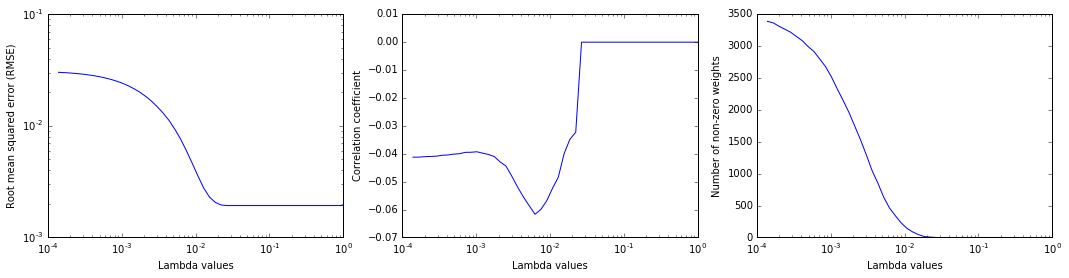

In [6]:
import pickle
import matplotlib
import matplotlib.pyplot as plt

with open("raw/encoder/lasso01_lam.raw", mode="br") as fbin:
    todo_lambda = pickle.load(fbin)

with open("raw/encoder/lasso01_err.raw", mode="br") as fbin:
    err_overlam = pickle.load(fbin)
    
with open("raw/encoder/lasso01_corr.raw", mode="br") as fbin:
    corr_overlam = pickle.load(fbin)
    
with open("raw/encoder/lasso01_spar.raw", mode="br") as fbin:
    spar_overlam = pickle.load(fbin)

myfig = plt.figure(figsize=(18,4))
ax_err = myfig.add_subplot(1, 3, 1)
plt.ylabel("Root mean squared error (RMSE)")
plt.xlabel("Lambda values")
ax_err.set_yscale('log')
ax_err.set_xscale('log')
ax_err.plot(todo_lambda, err_overlam)

ax_corr = myfig.add_subplot(1, 3, 2)
plt.ylabel("Correlation coefficient")
plt.xlabel("Lambda values")
ax_corr.set_xscale('log')
ax_corr.plot(todo_lambda, corr_overlam)

ax_spar = myfig.add_subplot(1, 3, 3)
plt.ylabel("Number of non-zero weights")
plt.xlabel("Lambda values")
ax_spar.set_xscale('log')
ax_spar.plot(todo_lambda, spar_overlam)

plt.show()


In [ ]:
corr_overlam

In [ ]:
w_est

In [ ]:
X_tr

In [ ]:
mod.n

In [ ]:
print("Mean =", np.mean(X_te, axis=0), "StdDev =", np.std(X_te, axis=0), "Shape =", X_te.shape)
